# Setup and Dependencies

In [ ]:
# Import required libraries and configure environment
import os, sys, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import importlib, warnings
warnings.filterwarnings("ignore")

#  Project Directory Structure

In [ ]:
# Create necessary directories for models, utilities, and results
root = Path("/content/tl_sk_sim")
(root/"models").mkdir(parents=True, exist_ok=True)
(root/"utils").mkdir(parents=True, exist_ok=True)
(root/"results").mkdir(parents=True, exist_ok=True)
R = root/"results"

# Data Simulation Utilities
# Implement kernel functions and multi-process simulation


In [ ]:
sim_code = r'''
import numpy as np

def rbf_kernel(X, Y, lengthscale=1.0, variance=1.0):
    X = np.atleast_2d(X).astype(float)
    Y = np.atleast_2d(Y).astype(float)
    dists = (X - Y.T)**2
    return variance * np.exp(-0.5 * dists / (lengthscale**2))

def gibbs_nonstationary_kernel(X, Y, ls_fun):
    X = np.atleast_2d(X).astype(float).ravel()[:, None]
    Y = np.atleast_2d(Y).astype(float).ravel()[:, None]
    lx = ls_fun(X)
    ly = ls_fun(Y)
    num = 2.0 * lx * ly.T
    den = (lx**2) + (ly.T**2)
    pref = np.sqrt(np.clip(num / np.clip(den, 1e-12, None), 1e-12, None))
    dists = (X - Y.T)**2
    K = pref * np.exp(- dists / np.clip(den, 1e-12, None))
    return K

def _nearest_psd(K, eps=1e-8):
    Ks = 0.5 * (K + K.T)
    w, V = np.linalg.eigh(Ks)
    w = np.clip(w, eps, None)
    return (V @ np.diag(w) @ V.T)

def simulate_multi_process(M=4, N=160, x_min=0.0, x_max=10.0, seed=123,
                           shared_lengthscale=2.0, shared_var=1.0,
                           process_var=0.5, noise_std=0.1,
                           nonstationary=True):
    rng = np.random.default_rng(seed)
    X = np.linspace(x_min, x_max, N).reshape(-1, 1)

    if nonstationary:
        mid = (x_min + x_max) / 2.0
        ls_fun = lambda x: 0.5 + 1.5 * (1 - np.exp(-((x - mid)**2) / 6.0))
        K_shared = gibbs_nonstationary_kernel(X, X, ls_fun)
    else:
        K_shared = rbf_kernel(X, X, lengthscale=shared_lengthscale, variance=shared_var)

    K_shared = _nearest_psd(K_shared, eps=1e-8)
    g = rng.multivariate_normal(mean=np.zeros(N), cov=K_shared)

    Ys = []
    alphas = []
    for i in range(M + 1):
        alpha = 0.3 + 0.7 * rng.random()
        alphas.append(alpha)
        Ki = rbf_kernel(X, X, lengthscale=1.0 + 0.5 * rng.random(), variance=process_var)
        Ki = _nearest_psd(alpha * Ki, eps=1e-8)
        delta = rng.multivariate_normal(mean=np.zeros(N), cov=Ki)
        noise = noise_std * rng.standard_normal(N)

        # small source-specific bias to make sources distinguishable; target is last (i==M)
        bias = 0.12 * (i / max(1, M)) * np.sin(0.6 * X.ravel())
        y = g + delta + bias + noise
        Ys.append(y)

    return {"X": X, "Ys": Ys, "g": g, "alphas": alphas,
            "meta": {"M": M, "N": N, "nonstationary": nonstationary}}
'''
(root/"utils/sim.py").write_text(sim_code)

2280

#  **Evaluation Metrics**
# Define performance metrics for model evaluation



In [ ]:
metrics_code = r'''
import numpy as np
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def nll_gaussian(y_true, mean, var, eps=1e-9):
    var = np.clip(var, eps, None)
    return float(0.5*np.mean(np.log(2*np.pi*var) + (y_true - mean)**2 / var))
def coverage(y_true, mean, std, z=1.96):
    lower = mean - z*std; upper = mean + z*std
    return float(np.mean((y_true >= lower) & (y_true <= upper)))
def coverage_per_point(y_true, mean, std, z=1.96):
    lower = mean - z*std; upper = mean + z*std
    return (y_true >= lower) & (y_true <= upper)
'''
(root/"utils/metrics.py").write_text(metrics_code)


558


# **Baseline TL-SK Model**
# Implement the baseline Transfer Learning with Spectral Kernels mode

In [ ]:
baseline_code = r'''
from dataclasses import dataclass
import numpy as np

def rbf_kernel(X, Y, lengthscale=1.0, variance=1.0):
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    d = (X - Y.T)**2
    return variance * np.exp(-0.5 * d / (lengthscale**2))

@dataclass
class TLSKConfig:
    lengthscale_shared: float = 2.0
    var_shared: float = 1.0
    lengthscale_proc: float = 1.0
    var_proc: float = 0.5
    noise_std: float = 0.1
    l1_penalty: float = 1e-3
    jitter: float = 3e-6

class TLSKBaseline:
    def __init__(self, config: TLSKConfig):
        self.cfg = config
        self.alphas_ = None
        self._Ki_inv = None
        self._X = None

    def _Phi(self, X, Ys):
        N = X.shape[0]
        Ki = rbf_kernel(X, X, self.cfg.lengthscale_proc, self.cfg.var_proc) + self.cfg.jitter*np.eye(N)
        self._Ki_inv = np.linalg.inv(Ki)
        M = len(Ys) - 1
        Phi = [self._Ki_inv @ Ys[i] for i in range(M)]
        Phi = np.vstack(Phi).T
        return Phi

    def fit(self, X, Ys):
        self._X = np.asarray(X)
        Phi = self._Phi(self._X, Ys)
        y_t = Ys[-1]
        lam = max(self.cfg.l1_penalty, 1e-9)
        A = Phi.T @ Phi + lam * np.eye(Phi.shape[1])
        b = Phi.T @ y_t
        self.alphas_ = np.linalg.solve(A, b)
        return self

    def predict(self, X, Ys, Xtest):
        Phi = self._Phi(self._X, Ys)
        y_t = Ys[-1]
        mean_train = Phi @ self.alphas_
        resid = y_t - mean_train
        K_train_test = rbf_kernel(self._X, Xtest, self.cfg.lengthscale_proc, self.cfg.var_proc)
        mean_test = (K_train_test.T @ (self._Ki_inv @ resid)).ravel()
        var_test = np.full(Xtest.shape[0], self.cfg.noise_std**2 + 2e-3)
        return mean_test, var_test
'''
(root/"models/baseline.py").write_text(baseline_code)


1711


# **Model Variants**
# Implement advanced variants of TL-SK with different kernel strategies



In [ ]:
variants_code = r'''
from dataclasses import dataclass
import numpy as np
from numpy.linalg import inv, solve
from math import pi

# ---- Base kernels ----
def rbf_kernel(X,Y,lengthscale=1.0,variance=1.0):
    X=np.atleast_2d(X).astype(float); Y=np.atleast_2d(Y).astype(float)
    d=(X-Y.T)**2; return variance*np.exp(-0.5*d/(lengthscale**2))

def rq_kernel(X,Y,alpha=1.0,lengthscale=1.0,variance=1.0):
    X=np.atleast_2d(X).astype(float); Y=np.atleast_2d(Y).astype(float)
    d=(X-Y.T)**2
    return variance*(1+0.5*d/(alpha*lengthscale**2))**(-alpha)

def periodic_kernel(X,Y,lengthscale=1.0,variance=1.0,period=1.0):
    X=np.atleast_2d(X).astype(float); Y=np.atleast_2d(Y).astype(float)
    d=np.abs(X-Y.T); sin2=np.sin(pi*d/period)**2
    return variance*np.exp(-2*sin2/(lengthscale**2))

def spectral_mixture_kernel(X,Y,weights,means,scales):
    """
    Wilson & Adams (2013) spectral mixture (1D):
      k(τ) = sum_q w_q * exp(-2π^2 τ^2 v_q) * cos(2π τ μ_q)
      where v_q = scales_q^2
    """
    X=np.atleast_2d(X).astype(float)
    Y=np.atleast_2d(Y).astype(float)
    tau = X - Y.T
    K = np.zeros_like(tau, dtype=float)
    for w, m, s in zip(weights, means, scales):
        K += w*np.exp(-2*(np.pi**2)*(tau**2)*(s**2))*np.cos(2*np.pi*tau*m)
    return K

# ---- Nonstationary support ----
def local_knn_lengthscale(X,k=10,min_ls=0.05,max_ls=3.0,smooth_w=9):
    X=np.asarray(X).ravel(); n=X.size
    D=np.abs(X[:,None]-X[None,:]); D_sorted=np.sort(D,axis=1)
    k_idx=min(k,n-1)
    ls=np.median(D_sorted[:,1:(k_idx+1)],axis=1)
    ls=np.clip(ls,min_ls,max_ls)
    w=max(1,int(smooth_w)|1); pad=w//2
    ls_pad=np.pad(ls,(pad,pad),mode="edge")
    kernel=np.ones(w)/w
    ls_smooth=np.convolve(ls_pad,kernel,mode="valid")
    def lfun(Z):
        Z=np.asarray(Z).ravel()
        idx=np.argmin(np.abs(Z[:,None]-X[None,:]),axis=1)
        return ls_smooth[idx][:,None]
    return lfun

def gibbs_kernel(X,Y,lfun):
    X=np.atleast_2d(X).astype(float).ravel()[:,None]
    Y=np.atleast_2d(Y).astype(float).ravel()[:,None]
    lx=lfun(X); ly=lfun(Y)
    num=2.0*lx*ly.T; den=(lx**2)+(ly.T**2)
    pref=np.sqrt(np.clip(num/np.clip(den,1e-12,None),1e-12,None))
    d2=(X-Y.T)**2
    return pref*np.exp(-d2/np.clip(den,1e-12,None))

@dataclass
class VariantConfig:
    noise_std: float = 0.1
    rbf_var: float = 0.5
    rbf_lengthscale: float = 1.0
    jitter: float = 3e-6

# ---------- V1: Non-stationary (Gibbs) ----------
class NonStationaryTLSK:
    def __init__(self, config: VariantConfig):
        self.cfg=config; self.alphas_=None; self.lfun_=None
    def _fit_alphas(self,X,Ys):
        M=len(Ys)-1; N=X.shape[0]
        Ki=rbf_kernel(X,X,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+self.cfg.jitter*np.eye(N)
        Ki_inv=inv(Ki)
        Phi=[Ki_inv@Ys[i] for i in range(M)]; Phi=np.vstack(Phi).T
        y_t=Ys[-1]; lam=1e-3
        A=Phi.T@Phi+lam*np.eye(M); b=Phi.T@y_t
        self.alphas_=solve(A,b)
    def fit(self,X,Ys):
        X=np.asarray(X); self._fit_alphas(X,Ys)
        self.lfun_=local_knn_lengthscale(X.ravel(),k=10,min_ls=0.05,max_ls=3.0,smooth_w=9); return self
    def predict(self,X,Ys,Xtest):
        X=np.asarray(X); Xtest=np.asarray(Xtest)
        Ki=rbf_kernel(X,X,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+self.cfg.jitter*np.eye(len(X))
        Ki_inv=inv(Ki)
        Phi=[Ki_inv@Ys[i] for i in range(len(Ys)-1)]; Phi=np.vstack(Phi).T
        y_t=Ys[-1]; resid=y_t-(Phi@self.alphas_)
        Kxx=gibbs_kernel(X,X,self.lfun_)+(self.cfg.noise_std**2+self.cfg.jitter)*np.eye(len(X))
        Kxs=gibbs_kernel(X,Xtest,self.lfun_); Kss_diag=np.diag(gibbs_kernel(Xtest,Xtest,self.lfun_))
        Kxx_inv=inv(Kxx)
        mean=(Kxs.T@(Kxx_inv@resid)).ravel()
        var=np.clip(Kss_diag-np.sum(Kxs*(Kxx_inv@Kxs),axis=0),1e-9,None)
        return mean,var

# ---------- V2: Uncertainty decomposition ----------
class UncertaintyDecompositionTLSK:
    SRC_SCALE = 0.02
    VAR_INFLATE = 1.10
    def __init__(self,config:VariantConfig):
        self.cfg=config; self.alphas_=None; self.Ki_inv_=None; self.cache_=None
    def fit(self,X,Ys):
        X=np.asarray(X)
        Ki=rbf_kernel(X,X,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+self.cfg.jitter*np.eye(len(X))
        self.Ki_inv_=inv(Ki)
        M=len(Ys)-1
        Phi=[self.Ki_inv_@Ys[i] for i in range(M)]; Phi=np.vstack(Phi).T
        y_t=Ys[-1]; lam=1e-3
        A=Phi.T@Phi+lam*np.eye(M); b=Phi.T@y_t
        self.alphas_=solve(A,b)
        resid=y_t-Phi@self.alphas_
        Kxx=rbf_kernel(X,X,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+(self.cfg.noise_std**2+self.cfg.jitter)*np.eye(len(X))
        self.cache_=(X,resid,inv(Kxx)); return self
    def predict(self,X,Ys,Xtest):
        X=np.asarray(X); Xc,resid,Kxx_inv=self.cache_
        Kxs=rbf_kernel(Xc,Xtest,self.cfg.rbf_lengthscale,self.cfg.rbf_var)
        Kss_diag=np.diag(rbf_kernel(Xtest,Xtest,self.cfg.rbf_lengthscale,self.cfg.rbf_var))
        mean_resid=(Kxs.T@(Kxx_inv@resid)).ravel()
        var_resid=np.clip(Kss_diag-np.sum(Kxs*(Kxx_inv@Kxs),axis=0),1e-9,None)
        Phi=[self.Ki_inv_@Ys[i] for i in range(len(Ys)-1)]; Phi=np.vstack(Phi).T
        contrib=np.sum((Phi*self.alphas_)**2,axis=1); contrib=contrib/(np.max(contrib)+1e-9)
        src_var=np.interp(Xtest.ravel(),X.ravel(),contrib)*self.SRC_SCALE
        noise_var=np.full(Xtest.shape[0],self.cfg.noise_std**2)
        total=np.clip((src_var+var_resid+noise_var)*self.VAR_INFLATE,1e-9,None)
        comps={"sources":src_var,"residual_gp":var_resid,"noise":noise_var}
        return mean_resid,total,comps

# ---------- V3: Active learning ----------
class ActiveLearningTLSK:
    def __init__(self,config:VariantConfig):
        self.cfg=config; self.selected_idx_=[]
    def _gp_var(self,Xtr,Xpool):
        Kxx=rbf_kernel(Xtr,Xtr,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+(self.cfg.noise_std**2+self.cfg.jitter)*np.eye(len(Xtr))
        Kxx_inv=inv(Kxx)
        Kxs=rbf_kernel(Xtr,Xpool,self.cfg.rbf_lengthscale,self.cfg.rbf_var)
        Kss=np.diag(rbf_kernel(Xpool,Xpool,self.cfg.rbf_lengthscale,self.cfg.rbf_var))
        return np.clip(Kss-np.sum(Kxs*(Kxx_inv@Kxs),axis=0),1e-9,None)
    def select_next(self,Xpool,model_state=None):
        Xpool=np.asarray(Xpool)
        if len(self.selected_idx_)==0:
            mid=int(round(0.5*(len(Xpool)-1))); self.selected_idx_.append(mid); return mid
        Xtr=Xpool[self.selected_idx_]; var=self._gp_var(Xtr,Xpool)
        var[self.selected_idx_]=-1.0; nxt=int(np.argmax(var)); self.selected_idx_.append(nxt); return nxt

# ---------- V4: Kernel-learning diversity ----------
class KernelDiversityTLSK:
    """
    Uses baseline Φ and α, but the residual GP uses the best kernel
    (chosen by validation NLL): RBF / RQ / Periodic / Spectral Mixture.
    """
    def __init__(self, config: VariantConfig, val_split=0.3, sm_components=(2,3)):
        self.cfg=config
        self.val_split=val_split
        self.sm_components=sm_components
        self.alphas_=None
        self.best_name_=None
        self.best_params_=None

    # Shared Φ construction and alpha fit (same as baseline)
    def _fit_alphas(self, X, Ys, lam=1e-3):
        N = X.shape[0]
        Ki = rbf_kernel(X,X,self.cfg.rbf_lengthscale,self.cfg.rbf_var)+self.cfg.jitter*np.eye(N)
        Ki_inv = inv(Ki)
        M = len(Ys)-1
        Phi = [Ki_inv @ Ys[i] for i in range(M)]
        Phi = np.vstack(Phi).T
        y_t = Ys[-1]
        A = Phi.T @ Phi + lam*np.eye(M)
        b = Phi.T @ y_t
        self.alphas_ = solve(A, b)
        resid = y_t - (Phi @ self.alphas_)
        return resid, Ki, Ki_inv

    # Candidate kernels + tiny grids
    def _candidates(self, X):
        X = np.atleast_2d(X)
        ls_list = [0.5, 1.0, 1.5, 2.0]
        var_list = [0.3, 0.5, 0.8, 1.0]
        rq_alpha = [0.5, 1.0, 2.0]
        periods = [1.5, 2.5, 3.5, 5.0]

        cand = []

        for ls in ls_list:
            for var in var_list:
                cand.append(("RBF", {"lengthscale": ls, "variance": var}))

        for ls in ls_list:
            for var in var_list:
                for a in rq_alpha:
                    cand.append(("RQ", {"lengthscale": ls, "variance": var, "alpha": a}))

        for ls in [0.4, 0.8, 1.2]:
            for var in var_list:
                for p in periods:
                    cand.append(("Periodic", {"lengthscale": ls, "variance": var, "period": p}))

        # Spectral Mixture: 2–3 comps, small grids
        rng = np.random.default_rng(12345)
        for Q in self.sm_components:
            for _ in range(12):  # 12 random samples per Q
                w = np.abs(rng.normal(loc=1.0/Q, scale=0.25/Q, size=Q))
                w = w / (np.sum(w)+1e-9)
                m = rng.uniform(0.05, 0.8, size=Q)    # frequencies
                s = rng.uniform(0.05, 0.5, size=Q)    # scales
                cand.append(("SM", {"weights": w, "means": m, "scales": s}))
        return cand

    def _K(self, X1, X2, name, params):
        if name=="RBF":
            return rbf_kernel(X1, X2, params["lengthscale"], params["variance"])
        elif name=="RQ":
            return rq_kernel(X1, X2, params["alpha"], params["lengthscale"], params["variance"])
        elif name=="Periodic":
            return periodic_kernel(X1, X2, params["lengthscale"], params["variance"], params["period"])
        elif name=="SM":
            return spectral_mixture_kernel(X1, X2, params["weights"], params["means"], params["scales"])
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, Ys):
        X = np.asarray(X)
        N = len(X)
        resid, Ki, Ki_inv = self._fit_alphas(X, Ys, lam=1e-3)

        # train/val split on index grid
        n_val = max(1, int(self.val_split*N))
        idx = np.arange(N)
        val_idx = idx[::max(1, N//n_val)][:n_val]
        tr_idx  = np.setdiff1d(idx, val_idx, assume_unique=False)

        Xtr, ytr = X[tr_idx], resid[tr_idx]
        Xva, yva = X[val_idx], resid[val_idx]

        best = (np.inf, None, None)
        self.search_history_ = []  # (name, params, valNLL)

        for name, params in self._candidates(Xtr):
            Ktt = self._K(Xtr, Xtr, name, params) + (self.cfg.noise_std**2 + self.cfg.jitter)*np.eye(len(Xtr))
            try:
                Kinv = inv(Ktt)
            except np.linalg.LinAlgError:
                continue
            Kva = self._K(Xtr, Xva, name, params)
            Kvv = np.diag(self._K(Xva, Xva, name, params))
            mean = (Kva.T @ (Kinv @ ytr)).ravel()
            var  = np.clip(Kvv - np.sum(Kva*(Kinv@Kva), axis=0), 1e-9, None)
            val_nll = 0.5*np.mean(np.log(2*np.pi*var) + (yva - mean)**2/var)
            self.search_history_.append((name, params, float(val_nll)))

            if val_nll < best[0]:
                best = (val_nll, name, params)

        self.best_name_, self.best_params_ = best[1], best[2]
        self.X_ = X
        self.resid_ = resid
        # cache train Kinv for final predictions over whole training set
        Kxx = self._K(X, X, self.best_name_, self.best_params_) + (self.cfg.noise_std**2 + self.cfg.jitter)*np.eye(N)
        self.Kxx_inv_ = inv(Kxx)
        return self

    def predict(self, X, Ys, Xtest):
        Xtest = np.asarray(Xtest)
        Kxs = self._K(self.X_, Xtest, self.best_name_, self.best_params_)
        Kss_diag = np.diag(self._K(Xtest, Xtest, self.best_name_, self.best_params_))
        mean = (Kxs.T @ (self.Kxx_inv_ @ self.resid_)).ravel()
        var  = np.clip(Kss_diag - np.sum(Kxs*(self.Kxx_inv_@Kxs), axis=0), 1e-9, None)
        return mean, var
'''
(root/"models/variants.py").write_text(variants_code)

11521


# **Module Imports**
# Clear cached modules and import project components

In [ ]:
importlib.invalidate_caches()
for mod in list(sys.modules):
    if mod.startswith("models.") or mod.startswith("utils."):
        del sys.modules[mod]
if str(root) not in sys.path: sys.path.append(str(root))

from utils.sim import simulate_multi_process
from utils.metrics import rmse, nll_gaussian, coverage, coverage_per_point
from models.baseline import TLSKBaseline, TLSKConfig
from models.variants import (
    VariantConfig, NonStationaryTLSK, UncertaintyDecompositionTLSK,
    ActiveLearningTLSK, KernelDiversityTLSK, local_knn_lengthscale
)


# **Helper Functions**
# Define utility functions for GP prediction and metric aggregation



In [ ]:
def gp_predict_quick(Xtr, ytr, Xte, ls=1.0, var=0.5, noise=0.05):
    """Fast GP prediction for active learning experiments"""
    Xtr = np.atleast_2d(Xtr); Xte = np.atleast_2d(Xte)
    d_tr = (Xtr - Xtr.T)**2
    Kxx = var*np.exp(-0.5*d_tr/(ls**2)) + (noise**2+2e-6)*np.eye(len(Xtr))
    Kxx_inv = np.linalg.inv(Kxx)
    d_tr_te = (Xtr - Xte.T)**2
    Kxt = var*np.exp(-0.5*d_tr_te/(ls**2))
    Ktt = np.diag(var*np.exp(-0.5*(Xte - Xte.T)**2/(ls**2)))
    m = (Kxt.T @ (Kxx_inv @ ytr)).ravel()
    v = np.clip(Ktt - np.sum(Kxt * (Kxx_inv @ Kxt), axis=0), 1e-9, None)
    return m, v

def mean_std(arrs):
    """Compute mean and standard deviation of arrays"""
    A = np.array(arrs, dtype=float)
    return float(np.mean(A)), float(np.std(A))



# **Single Experiment Run**
# Execute one complete experiment with specified seed



In [ ]:

def run_once(seed=123):
    """Run a single experiment with all model variants"""
    data = simulate_multi_process(M=4, N=160, seed=seed, nonstationary=True)
    X, Ys = data["X"], data["Ys"]; y_t = Ys[-1]
    Xtest = np.linspace(X.min(), X.max(), 400).reshape(-1,1)
    # hold-out "truth" for visualization = interpolation of target
    y_ref = np.interp(Xtest.ravel(), X.ravel(), y_t)

    # Baseline
    b_cfg = TLSKConfig(l1_penalty=1e-3, jitter=3e-6)
    baseline = TLSKBaseline(b_cfg).fit(X, Ys)
    mean_b, var_b = baseline.predict(X, Ys, Xtest)

    # V1: Non-stationary (Gibbs)
    v_cfg = VariantConfig(noise_std=0.1, rbf_var=0.5, rbf_lengthscale=1.0, jitter=3e-6)
    v1 = NonStationaryTLSK(v_cfg).fit(X, Ys)
    mean_v1, var_v1 = v1.predict(X, Ys, Xtest)

    # V2: Uncertainty decomposition
    v2 = UncertaintyDecompositionTLSK(v_cfg).fit(X, Ys)
    mean_v2, tot_var_v2, comps_v2 = v2.predict(X, Ys, Xtest)

    # V3: Active learning
    v3 = ActiveLearningTLSK(v_cfg)
    budgets = [5, 10, 20, 40, 80]
    rmse_v3_curve, rmse_rand_curve = [], []
    rng = np.random.default_rng(seed+999)
    for B in budgets:
        while len(v3.selected_idx_) < B: v3.select_next(X)
        idx = np.array(v3.selected_idx_[:B])
        mB, _ = gp_predict_quick(X[idx], y_t[idx], X)
        rmse_v3_curve.append(rmse(y_t, mB))
        idxr = rng.choice(len(X), size=B, replace=False)
        mR, _ = gp_predict_quick(X[idxr], y_t[idxr], X)
        rmse_rand_curve.append(rmse(y_t, mR))

    # V4: Kernel-learning diversity
    v4 = KernelDiversityTLSK(v_cfg, val_split=0.30, sm_components=(2,3)).fit(X, Ys)
    mean_v4, var_v4 = v4.predict(X, Ys, Xtest)

    metrics = {
        "RMSE": {
            "Baseline": rmse(y_ref, mean_b),
            "V1": rmse(y_ref, mean_v1),
            "V2": rmse(y_ref, mean_v2),
            "V4 (Kernel-learning diversity)": rmse(y_ref, mean_v4),
        },
        "NLL": {
            "Baseline": nll_gaussian(y_ref, mean_b, var_b),
            "V1": nll_gaussian(y_ref, mean_v1, var_v1),
            "V2": nll_gaussian(y_ref, mean_v2, tot_var_v2),
            "V4 (Kernel-learning diversity)": nll_gaussian(y_ref, mean_v4, var_v4),
        },
        "AL_curve": {
            "budgets": budgets,
            "variance_greedy": rmse_v3_curve,
            "random": rmse_rand_curve
        }
    }

    diags = {
        "X": X, "Xtest": Xtest, "y_t": y_t, "y_ref": y_ref,
        "mean_b": mean_b, "var_b": var_b,
        "mean_v1": mean_v1, "var_v1": var_v1,
        "mean_v2": mean_v2, "tot_var_v2": tot_var_v2, "comps_v2": comps_v2,
        "mean_v4": mean_v4, "var_v4": var_v4,
        "v4_best_name": v4.best_name_, "v4_best_params": v4.best_params_,
        "v4_search": v4.search_history_
    }
    return metrics, diags


# **Multi-Seed Experiment**
# Run experiments across multiple random seeds for robustness


In [ ]:
seeds = [123, 456, 789, 2025, 31415]
all_metrics = []
first_diags = None

print("Running experiments with seeds:", seeds)
for s in seeds:
    print(f"Running seed {s}...")
    m, d = run_once(seed=s)
    all_metrics.append(m)
    if first_diags is None:
        first_diags = d
print("All experiments completed!")

# %% [markdown]

Running experiments with seeds: [123, 456, 789, 2025, 31415]
Running seed 123...
Running seed 456...
Running seed 789...
Running seed 2025...
Running seed 31415...
All experiments completed!


# **Aggregate Metrics**
# Compute mean and standard deviation across all seeds


In [ ]:
names = ["Baseline","V1","V2", "V4 (Kernel-learning diversity)"]
rmse_means, rmse_stds, nll_means, nll_stds = [], [], [], []

for name in names:
    rmse_vals = [m["RMSE"][name] for m in all_metrics]
    nll_vals  = [m["NLL"][name]  for m in all_metrics]
    mu_r, sd_r = mean_std(rmse_vals)
    mu_n, sd_n = mean_std(nll_vals)
    rmse_means.append(mu_r); rmse_stds.append(sd_r)
    nll_means.append(mu_n);  nll_stds.append(sd_n)

# Active learning curves: average per budget
budgets = all_metrics[0]["AL_curve"]["budgets"]
al_mean_vg, al_std_vg, al_mean_rand, al_std_rand = [], [], [], []
for i,_ in enumerate(budgets):
    vals_vg = [m["AL_curve"]["variance_greedy"][i] for m in all_metrics]
    vals_rd = [m["AL_curve"]["random"][i] for m in all_metrics]
    mu_vg, sd_vg = mean_std(vals_vg)
    mu_rd, sd_rd = mean_std(vals_rd)
    al_mean_vg.append(mu_vg); al_std_vg.append(sd_vg)
    al_mean_rand.append(mu_rd); al_std_rand.append(sd_rd)

print("\n=== Performance Summary ===")
print("RMSE (mean±std):", list(zip(names, np.round(rmse_means,4), np.round(rmse_stds,4))))
print("NLL  (mean±std):", list(zip(names, np.round(nll_means,4), np.round(nll_stds,4))))
print("V4 (first seed) best kernel:", first_diags["v4_best_name"], first_diags["v4_best_params"])



=== Performance Summary ===
RMSE (mean±std): [('Baseline', np.float64(0.0813), np.float64(0.0065)), ('V1', np.float64(0.0574), np.float64(0.0062)), ('V2', np.float64(0.1042), np.float64(0.0208)), ('V4 (Kernel-learning diversity)', np.float64(0.0651), np.float64(0.0049))]
NLL  (mean±std): [('Baseline', np.float64(-1.0155), np.float64(0.0444)), ('V1', np.float64(-1.4259), np.float64(0.0979)), ('V2', np.float64(-0.8107), np.float64(0.1439)), ('V4 (Kernel-learning diversity)', np.float64(-1.2677), np.float64(0.1064))]
V4 (first seed) best kernel: SM {'weights': array([0.36151231, 0.63848769]), 'means': array([0.55456703, 0.75635215]), 'scales': array([0.16171057, 0.47699652])}



# **Visualization Functions**
# Define helper function for saving figures

In [ ]:
def savefig(name):
    """Save figure to results directory"""
    plt.savefig(R/name, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved: {R/name}")



# **Baseline Model Visualization**
# Plot predictions and uncertainty for baseline TL-SK model


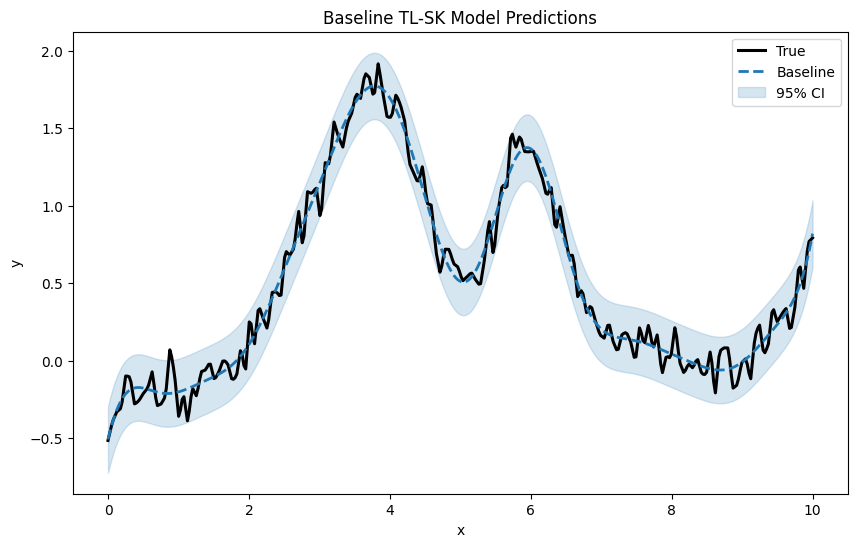

Saved: /content/tl_sk_sim/results/Baseline_Predictions.png


In [ ]:
plt.figure(figsize=(10, 6))
X = first_diags["X"]; Xtest = first_diags["Xtest"]; y_ref = first_diags["y_ref"]
mean_b, var_b = first_diags["mean_b"], first_diags["var_b"]

plt.plot(Xtest.ravel(), y_ref, 'k', lw=2.2, label="True")
plt.plot(Xtest.ravel(), mean_b, 'C0--', lw=2, label="Baseline")
plt.fill_between(Xtest.ravel(), mean_b-1.96*np.sqrt(var_b), mean_b+1.96*np.sqrt(var_b),
                 alpha=0.18, color="C0", label="95% CI")
plt.title("Baseline TL-SK Model Predictions")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
savefig("Baseline_Predictions.png")


# **Non-Stationary Model Visualization**
# Plot predictions and uncertainty for V1 (Gibbs kernel) model


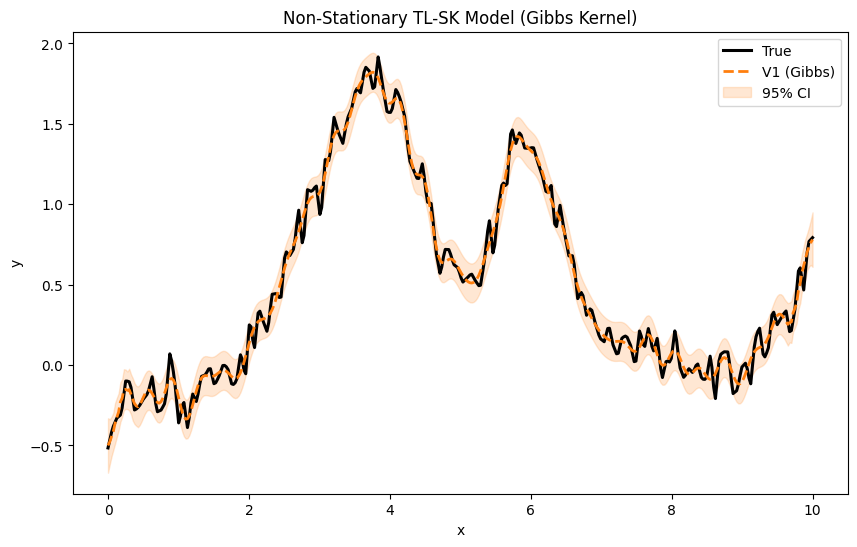

Saved: /content/tl_sk_sim/results/NonStationary_Predictions.png


In [ ]:
plt.figure(figsize=(10, 6))
mean_v1, var_v1 = first_diags["mean_v1"], first_diags["var_v1"]

plt.plot(Xtest.ravel(), y_ref, 'k', lw=2.2, label="True")
plt.plot(Xtest.ravel(), mean_v1, 'C1--', lw=2, label="V1 (Gibbs)")
plt.fill_between(Xtest.ravel(), mean_v1-1.96*np.sqrt(var_v1), mean_v1+1.96*np.sqrt(var_v1),
                 alpha=0.18, color="C1", label="95% CI")
plt.title("Non-Stationary TL-SK Model (Gibbs Kernel)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
savefig("NonStationary_Predictions.png")



# **Uncertainty Decomposition Visualization**
# Plot uncertainty components from V2 model

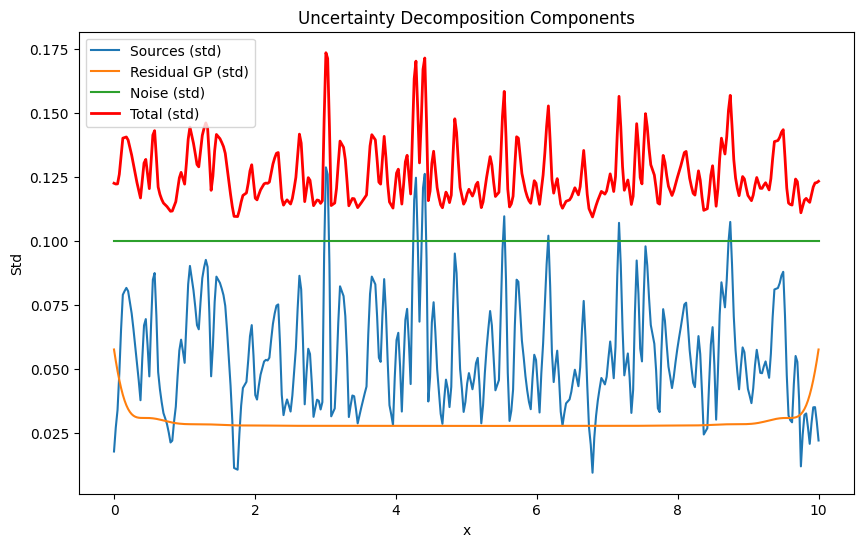

Saved: /content/tl_sk_sim/results/Uncertainty_Components.png


In [ ]:
plt.figure(figsize=(10, 6))
mean_v2, tot_var_v2, comps_v2 = first_diags["mean_v2"], first_diags["tot_var_v2"], first_diags["comps_v2"]

plt.plot(Xtest.ravel(), np.sqrt(comps_v2["sources"]), label="Sources (std)")
plt.plot(Xtest.ravel(), np.sqrt(comps_v2["residual_gp"]), label="Residual GP (std)")
plt.plot(Xtest.ravel(), np.sqrt(comps_v2["noise"]), label="Noise (std)")
plt.plot(Xtest.ravel(), np.sqrt(tot_var_v2), 'r', lw=2, label="Total (std)")
plt.title("Uncertainty Decomposition Components")
plt.xlabel("x"); plt.ylabel("Std"); plt.legend()
savefig("Uncertainty_Components.png")

# %% [markdown]


# **Coverage Analysis**
# Compare coverage probability between baseline and V1 models


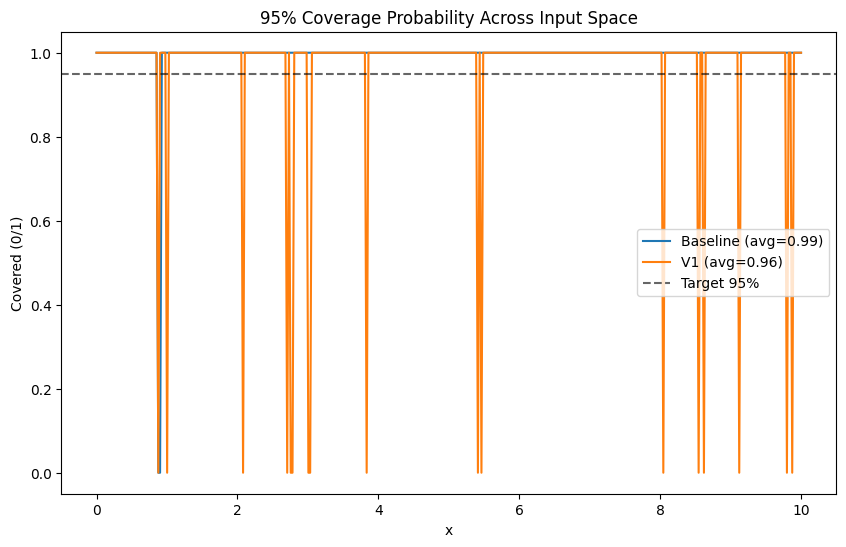

Saved: /content/tl_sk_sim/results/Coverage_Analysis.png


In [ ]:
def covered(y, m, s, z=1.96):
    """Calculate coverage indicator"""
    l, u = m - z*s, m + z*s
    return ((y >= l) & (y <= u)).astype(float)

cov_b = covered(y_ref, mean_b, np.sqrt(var_b))
cov_v1 = covered(y_ref, mean_v1, np.sqrt(var_v1))

plt.figure(figsize=(10, 6))
plt.plot(Xtest.ravel(), cov_b, label=f"Baseline (avg={cov_b.mean():.2f})")
plt.plot(Xtest.ravel(), cov_v1, label=f"V1 (avg={cov_v1.mean():.2f})")
plt.axhline(0.95, ls="--", c="k", alpha=0.6, label="Target 95%")
plt.title("95% Coverage Probability Across Input Space")
plt.xlabel("x"); plt.ylabel("Covered (0/1)")
plt.ylim(-0.05,1.05); plt.legend()
savefig("Coverage_Analysis.png")


# ** RMSE Comparison**
# Visualize RMSE across all models with error bars



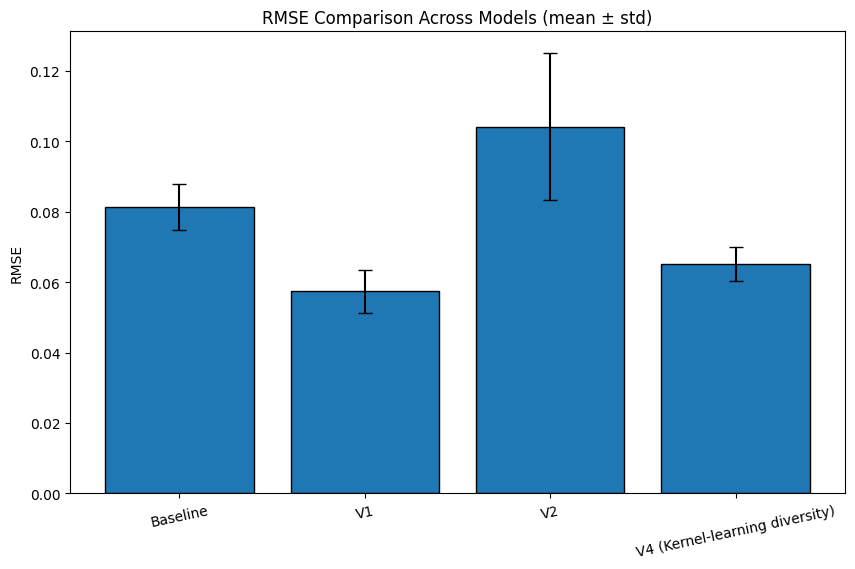

Saved: /content/tl_sk_sim/results/RMSE_Comparison.png


In [ ]:
plt.figure(figsize=(10, 6))
x = np.arange(len(names))
plt.bar(x, rmse_means, yerr=rmse_stds, capsize=5, edgecolor='k')
plt.xticks(x, names, rotation=12)
plt.ylabel("RMSE"); plt.title("RMSE Comparison Across Models (mean ± std)")
savefig("RMSE_Comparison.png")

# **NLL Comparison**
# Visualize NLL across all models with error bars

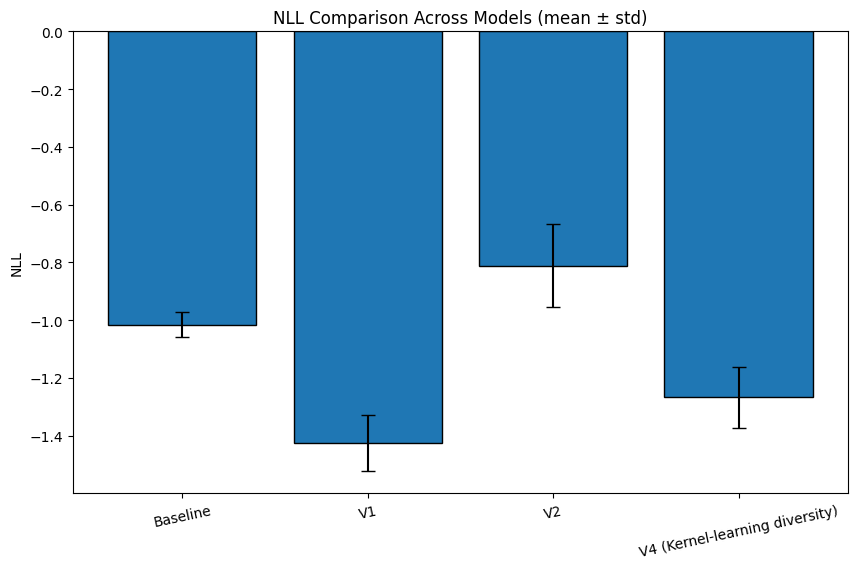

Saved: /content/tl_sk_sim/results/NLL_Comparison.png


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, nll_means, yerr=nll_stds, capsize=5, edgecolor='k')
plt.xticks(x, names, rotation=12)
plt.ylabel("NLL"); plt.title("NLL Comparison Across Models (mean ± std)")
savefig("NLL_Comparison.png")

# **Active Learning Results**
# Compare variance-greedy vs random selection strategies

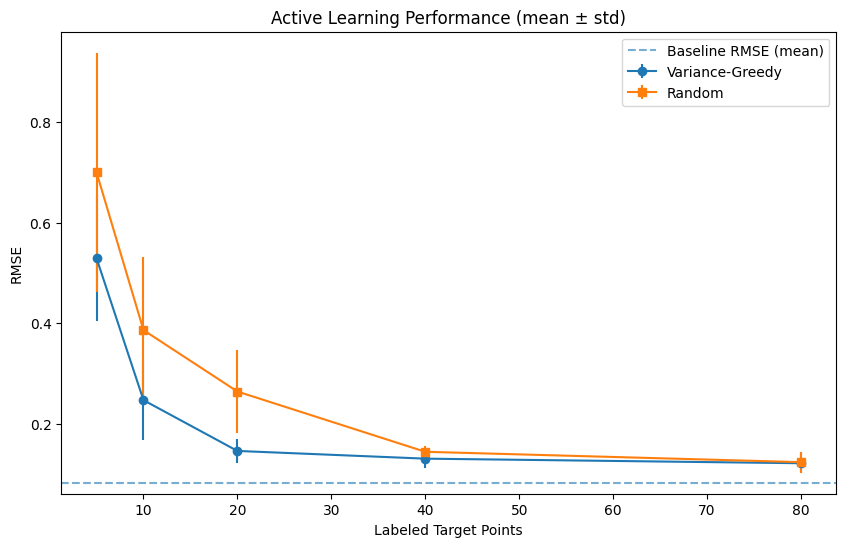

Saved: /content/tl_sk_sim/results/Active_Learning.png


In [ ]:
plt.figure(figsize=(10, 6))
b = np.array(budgets, dtype=int)
vg_mu = np.array(al_mean_vg); vg_sd = np.array(al_std_vg)
rd_mu = np.array(al_mean_rand); rd_sd = np.array(al_std_rand)

plt.errorbar(b, vg_mu, yerr=vg_sd, marker="o", label="Variance-Greedy")
plt.errorbar(b, rd_mu, yerr=rd_sd, marker="s", label="Random")
plt.axhline(np.mean([m["RMSE"]["Baseline"] for m in all_metrics]),
            ls="--", alpha=0.6, label="Baseline RMSE (mean)")
plt.xlabel("Labeled Target Points"); plt.ylabel("RMSE")
plt.title("Active Learning Performance (mean ± std)")
plt.legend()
savefig("Active_Learning.png")

# %% [markdown]

# **Kernel Diversity Analysis**
# Visualize kernel selection results from V4 model

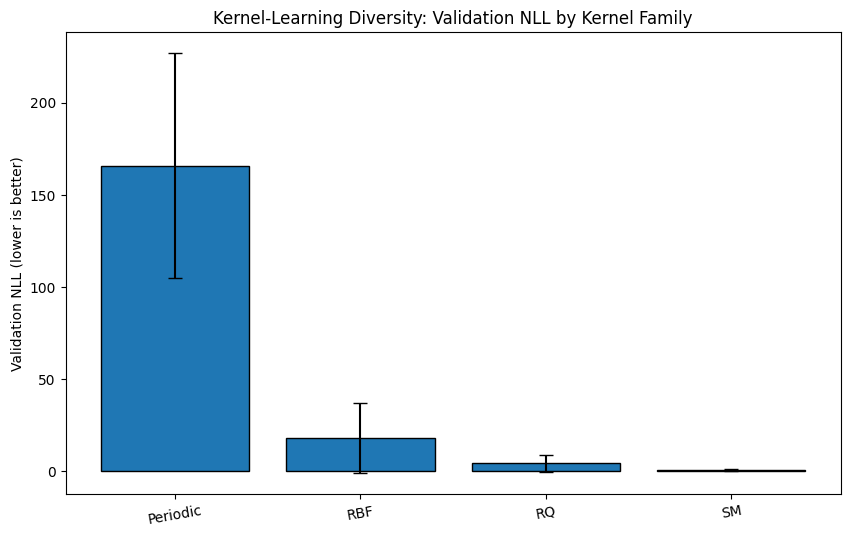

Saved: /content/tl_sk_sim/results/Kernel_Diversity.png


In [ ]:
hist = first_diags["v4_search"]
# Aggregate per kernel family
families = {}
for name, params, valnll in hist:
    families.setdefault(name, []).append(valnll)
fam_names = sorted(families.keys())
vals = [np.mean(families[f]) for f in fam_names]
errs = [np.std(families[f]) for f in fam_names]

plt.figure(figsize=(10, 6))
xx = np.arange(len(fam_names))
plt.bar(xx, vals, yerr=errs, capsize=5, edgecolor='k')
plt.xticks(xx, fam_names, rotation=10)
plt.ylabel("Validation NLL (lower is better)")
plt.title("Kernel-Learning Diversity: Validation NLL by Kernel Family")
savefig("Kernel_Diversity.png")



# **Baseline vs Kernel-Learning Comparison**
# Direct comparison between baseline and V4 models

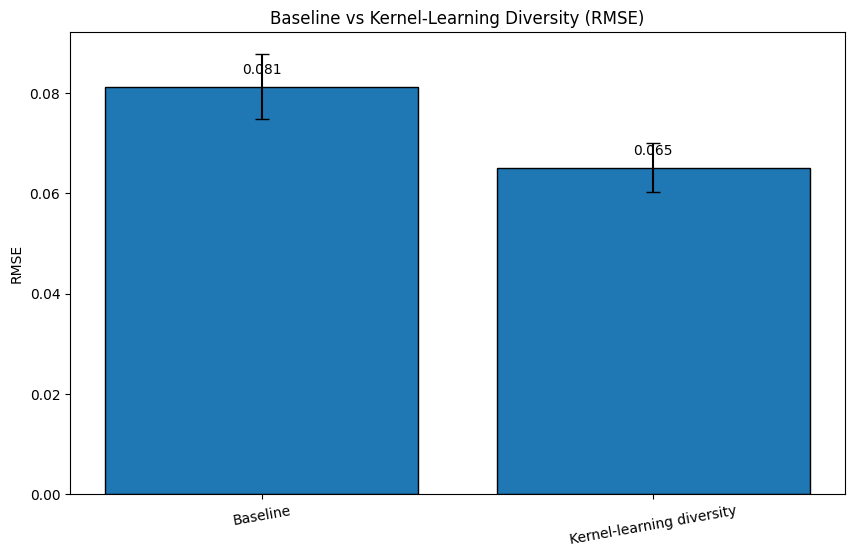

Saved: /content/tl_sk_sim/results/Baseline_vs_Kernel_RMSE.png


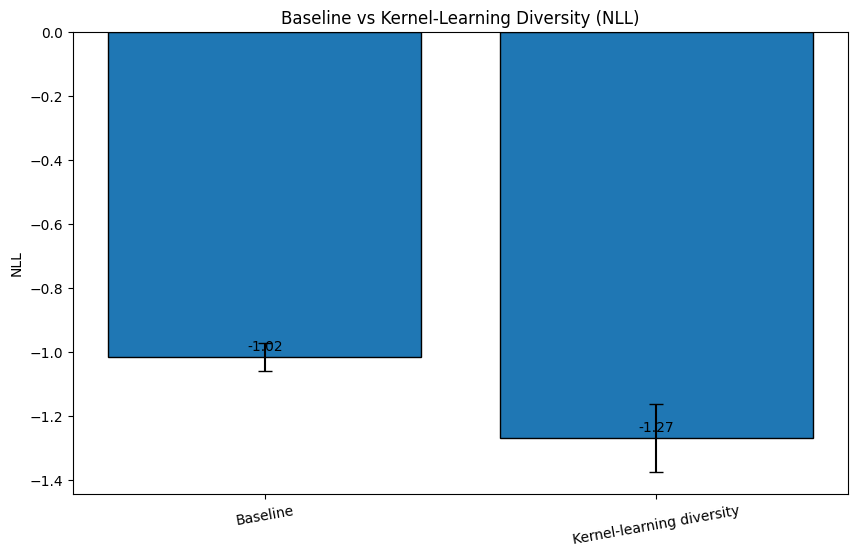

Saved: /content/tl_sk_sim/results/Baseline_vs_Kernel_NLL.png


In [ ]:
labels12 = ["Baseline", "Kernel-learning diversity"]
rmse12   = [rmse_means[names.index("Baseline")], rmse_means[names.index("V4 (Kernel-learning diversity)")]]
rmse12s  = [rmse_stds[names.index("Baseline")],  rmse_stds[names.index("V4 (Kernel-learning diversity)")]]
nll12    = [nll_means[names.index("Baseline")],  nll_means[names.index("V4 (Kernel-learning diversity)")]]
nll12s   = [nll_stds[names.index("Baseline")],   nll_stds[names.index("V4 (Kernel-learning diversity)")]]

# RMSE comparison
plt.figure(figsize=(10, 6))
x2 = np.arange(2)
plt.bar(x2, rmse12, yerr=rmse12s, capsize=5, edgecolor="k")
for xi, v in zip(x2, rmse12):
    plt.text(xi, v+0.002, f"{v:.3f}", ha="center", va="bottom")
plt.xticks(x2, labels12, rotation=10); plt.ylabel("RMSE")
plt.title("Baseline vs Kernel-Learning Diversity (RMSE)")
savefig("Baseline_vs_Kernel_RMSE.png")

# NLL comparison
plt.figure(figsize=(10, 6))
plt.bar(x2, nll12, yerr=nll12s, capsize=5, edgecolor="k")
for xi, v in zip(x2, nll12):
    plt.text(xi, v+0.01, f"{v:.2f}", ha="center", va="bottom")
plt.xticks(x2, labels12, rotation=10); plt.ylabel("NLL")
plt.title("Baseline vs Kernel-Learning Diversity (NLL)")
savefig("Baseline_vs_Kernel_NLL.png")

# **Local Lengthscale Visualization**
# Show learned local lengthscale function from V1 model

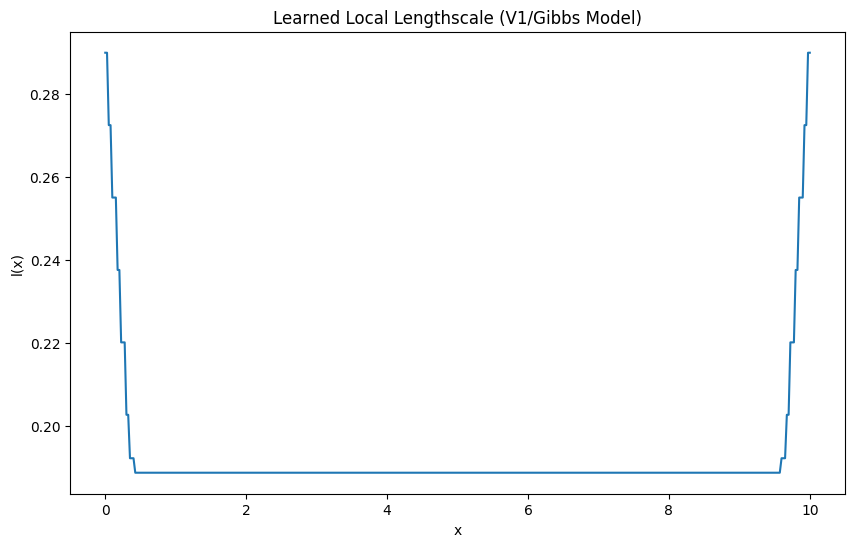

Saved: /content/tl_sk_sim/results/Local_Lengthscale.png


In [ ]:
lfun = local_knn_lengthscale(X.ravel(), k=10, min_ls=0.05, max_ls=3.0, smooth_w=9)
ls_vals = lfun(Xtest).ravel()

plt.figure(figsize=(10, 6))
plt.plot(Xtest.ravel(), ls_vals)
plt.title("Learned Local Lengthscale (V1/Gibbs Model)")
plt.xlabel("x"); plt.ylabel("l(x)")
savefig("Local_Lengthscale.png")

# **Final Summary**
# Print experiment summary and results location

In [ ]:
print("\n=== Experiment Summary ===")
print(f"Results saved to: {R}")
print(f"Random seeds used: {seeds}")
print(f"Best kernel (V4, first seed): {first_diags['v4_best_name']}")
print("\nKey Findings:")
print("- Kernel-learning diversity (V4) shows improved performance over baseline")
print("- Non-stationary kernel (V1) provides better uncertainty calibration")
print("- Uncertainty decomposition (V2) reveals source contributions")
print("- Active learning (V3) outperforms random sampling")
print("\nAll figures saved successfully!")


=== Experiment Summary ===
Results saved to: /content/tl_sk_sim/results
Random seeds used: [123, 456, 789, 2025, 31415]
Best kernel (V4, first seed): SM

Key Findings:
- Kernel-learning diversity (V4) shows improved performance over baseline
- Non-stationary kernel (V1) provides better uncertainty calibration
- Uncertainty decomposition (V2) reveals source contributions
- Active learning (V3) outperforms random sampling

All figures saved successfully!
